# Imports and installs

In [26]:
# #Only Rafa
from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

In [27]:
import pandas as pd
import os
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
from scipy.stats import mode
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
import numpy as np
import xgboost as xgb
import sklearn
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
import sklearn
import shap
from sklearn.metrics import r2_score, accuracy_score, precision_score

# Loading the Dataframe

## Merging the Seasons csv files (2019-2020 untill 2021-2022)

In [28]:
# Customise based on your path and folder organisation
print(os.listdir('../raw_data/All4'))

['spain_2019_2020_1.csv', 'italy_2020_2021_2.csv', 'italy_2021_2022_1.csv', 'italy_2021_2022_2.csv', 'spain_2020_2021_1.csv', 'spain_2020_2021_2.csv', 'scotland_2020_2021_2.csv', 'Turkey_2021_2022_1.csv', 'scotland_2020_2021_3.csv', 'scotland_2019_2020_1.csv', 'france_2021_2022_1.csv', 'germany_2021_2022_1.csv', 'belgium_2020_2021_1.csv', 'scotland_2021_2022_4.csv', 'scotland_2020_2021_1.csv', 'france_2019_2020_1.csv', 'germany_2021_2022_2.csv', 'germany_2019_2020_1.csv', 'england_2020_2021_3.csv', 'scotland_2019_2020_2.csv', 'italy_2019_2020_1.csv', 'scotland_2020_2021_4.csv', 'portugal_2021_2022_1.csv', 'france_2020_2021_2.csv', 'scotland_2021_2022_3.csv', 'england_2021_2022_3.csv', 'portugal_2019_2020_1.csv', 'Greece_2021_2022_1.csv', 'england_2020_2021_4.csv', 'england_2021_2022_4.csv', 'france_2020_2021_1.csv', 'germany_2020_2021_1.csv', 'scotland_2019_2020_4.csv', 'spain_2019_20220_2.csv', 'germany_2019_2020_2.csv', 'england_2019_2020_4.csv', 'scotland_2021_2022_1.csv', 'england_

In [29]:
# Concatenate all the CSVs
files = [file for file in os.listdir('../raw_data/All4') if file.endswith('.csv')]
data = pd.DataFrame()

for file in files:
    df = pd.read_csv('../raw_data/All4/' + file)
    df['country']=str(file)[0:2]
    df['country_division']=int(str(file)[-5:-4])
    data = pd.concat([data, df])

In [30]:
# Getting all data

def get_data(league1, wall=False):
    if wall:
        data = pd.DataFrame()
        leagues = listdir(f'./../raw_data/')
        data = pd.DataFrame()
        for league in leagues:
            files = listdir(f'./../raw_data/{league}')
            for file in files:
                df = pd.read_csv((f'./../raw_data/{league}/'+file))
                df['country']=str(file)[0:2]
                data = pd.concat([data, df])
        return data
    else:
        files = [file for file in listdir(f'./../raw_data/{league1}')]
        data = pd.DataFrame()
        for file in files:
            df = pd.read_csv(f'./../raw_data/{league1}/'+file)
            data = pd.concat([data, df])
        return data

# Features Engineering

In [31]:
#Loading the function

def feature_engineering(data, b=20, binned=False):
    '''
    This function creates all the columns that will be needed to create the analysis 
    and return the dataframe with all this changes
    
    b is the number of bins that we want to work with. Our start value for b will be 20.
        '''
    #------------------------Number of Goals, Over and Under -----------------------------------
    
    # total number of goals = goals from the home team + goals from visiting team
    data['nb_goals']=data['FTHG']+data['FTAG']

    # boolean: true or false regarding whether they were more than 2.5 goals
    data['over_2.5_goals']=data['nb_goals']>2.5

    # boolean: true or false regarding whether they were less than 2.5 goals
    data['under_2.5_goals']=data['nb_goals']<2.5
    
    #-----------------------------Payout Opening ----------------------------------------------
    
    # payout under 2.5 for Average OPENING odds
    data['payout_avg_under_2.5'] = data['under_2.5_goals']*data['Avg<2.5']

    # payout over 2.5 for Average OPENING odds
    data['payout_avg_over_2.5'] = data['over_2.5_goals']*data['Avg>2.5']

    #payout UNDER 2.5 for PINACLE specifically
    data['payout_under_2.5_pinacle'] = data['under_2.5_goals']*data['P<2.5']

    #payout OVER 2.5 for PINACLE specifically
    data['payout_over_2.5_pinacle'] = data['over_2.5_goals']*data['P>2.5']

    #payout UNDER 2.5 for 365 specifically
    data['payout_under_2.5_365'] = data['under_2.5_goals']*data['B365<2.5']

    #payout OVER 2.5 for 365 specifically
    data['payout_over_2.5_365'] = data['over_2.5_goals']*data['B365>2.5']
    
    #------------------------------Payout Closing --------------------------------------------
    
    # payout under 2.5 for Average CLOSING odds
    data['payout_avg_under_closing_2.5'] = data['under_2.5_goals']*data['AvgC<2.5']

    # payout over 2.5 for Average CLOSING odds
    data['payout_avg_over_closing_2.5'] = data['over_2.5_goals']*data['AvgC>2.5']

    #payout UNDER 2.5 for PINACLE closing ddds specifically
    data['payout_under_2.5_pinacle_closing'] = data['under_2.5_goals']*data['PC<2.5']

    #payout OVER 2.5 for PINACLE closing odds specifically
    data['payout_over_2.5_pinacle_closing'] = data['over_2.5_goals']*data['PC>2.5']

    #payout UNDER 2.5 for 365 closing odds specifically
    data['payout_under_2.5_365_closing'] = data['under_2.5_goals']*data['B365C<2.5']

    #payout OVER 2.5 for 365 closing odds specifically
    data['payout_over_2.5_365_closing'] = data['over_2.5_goals']*data['B365C>2.5']
    
    #-------------------------- Implied Probability Opening ----------------------------------------
    
    #Implied Probability UNDER 2.5 goals for for overall market opening odds (Avg) 
    data['Implied Probability <2.5 avg']=1/data['Avg<2.5']*100

    #Implied Probability OVER 2.5 goals for for overall market opening odds (Avg) 
    data['Implied Probability >2.5 avg']=1/data['Avg>2.5']*100

    #Implied Probability UNDER 2.5 goals for PINACLE
    data['Implied Probability <2.5 pinacle']=1/data['P<2.5']*100

    #Implied Probability OVER 2.5 goals for PINACLE
    data['Implied Probability >2.5 pinacle']=1/data['P>2.5']*100

    #Implied Probability UNDER 2.5 goals for 365
    data['Implied Probability <2.5 365']=1/data['B365<2.5']*100

    #Implied Probability OVER 2.5 goals for 365
    data['Implied Probability >2.5 365']=1/data['B365>2.5']*100
    
    #------------------------- Implied Probability Closing -----------------------------------
    
    #Implied Probability UNDER 2.5 goals for overall market closing odds (AvgC)
    data['Implied Probability <2.5 avg closing']=1/data['AvgC<2.5']*100

    #Implied Probability OVER 2.5 goals for overall market closing odds (AvgC)
    data['Implied Probability >2.5 avg closing']=1/data['AvgC>2.5']*100

    #Implied Probability UNDER 2.5 goals for PINACLE closing odds
    data['Implied Probability <2.5 pinacle closing']=1/data['PC<2.5']*100

    #Implied Probability OVER 2.5 goals for PINACLE closing odds
    data['Implied Probability >2.5 pinacle closing']=1/data['PC>2.5']*100

    #Implied Probability UNDER 2.5 goals for 365 closing odds
    data['Implied Probability <2.5 365 closing']=1/data['B365C<2.5']*100

    #Implied Probability OVER 2.5 goals for 365 closing odds
    data['Implied Probability >2.5 365 closing']=1/data['B365C>2.5']*100
    
    #---------------------------- Binning IP Opening -------------------------------------

    b=b
    bins = np.arange(0, 101, int(100/b))
    bins = bins.tolist()

    #Binning UNDER 2.5 Average Market opening odds
    data['binned <2.5 avg'] = pd.cut(data['Implied Probability <2.5 avg'], bins)

    #Binning Over 2.5 Average Market opening odds
    data['binned >2.5 avg'] = pd.cut(data['Implied Probability >2.5 avg'], bins)

    #Binned UNDER 2.5 Pinnacle opening odds
    data['binned <2.5 pinacle'] = pd.cut(data['Implied Probability <2.5 pinacle'], bins)

    #Binned OVER 2.5 Pinnacle
    data['binned >2.5 pinacle'] = pd.cut(data['Implied Probability >2.5 pinacle'], bins)

    #Binned UNDER 2.5 bet365 OPENING odds
    data['binned <2.5 365'] = pd.cut(data['Implied Probability <2.5 365'], bins)

    #Binned OVER 2.5 bet365 OPENING odds
    data['binned >2.5 365'] = pd.cut(data['Implied Probability >2.5 365'], bins)
    
    #----------------------------- Binning IP Closing ------------------------------------------------

    #Binning UNDER 2.5 Average Market closing odds
    data['binned <2.5 avg closing'] = pd.cut(data['Implied Probability <2.5 avg closing'], bins)

    #Binning OVER 2.5 Average Market closing odds
    data['binned >2.5 avg closing'] = pd.cut(data['Implied Probability >2.5 avg closing'], bins)

    #Binned UNDER 2.5 Pinnacle closing odds
    data['binned <2.5 pinacle closing'] = pd.cut(data['Implied Probability <2.5 pinacle closing'], bins)

    #Binned OVER 2.5 Pinnacle CLOSING odds
    data['binned >2.5 pinacle closing'] = pd.cut(data['Implied Probability >2.5 pinacle closing'], bins)

    #Binned UNDER 2.5 bet365 CLOSING odds
    data['binned <2.5 365 closing'] = pd.cut(data['Implied Probability <2.5 365 closing'], bins)

    #Binned OVER 2.5 bet365 CLOSING odds
    data['binned >2.5 365 closing'] = pd.cut(data['Implied Probability >2.5 365 closing'], bins)
    
    #---------------------------- Binning Odds Opening ----------------------------------------------------
    
    bins2 = [1, 1.5, 2, 3, 10]

    #Binning UNDER 2.5 Average Market opening odds
    data['binned odds <2.5 avg'] = pd.cut(data['Avg<2.5'], bins2)

    #Binning Over 2.5 Average Market opening odds
    data['binned odds >2.5 avg'] = pd.cut(data['Avg>2.5'], bins2)

    #Binned UNDER 2.5 Pinnacle opening odds
    data['binned odds <2.5 pinacle'] = pd.cut(data['P<2.5'], bins2)

    #Binned OVER 2.5 Pinnacle
    data['binned odds >2.5 pinacle'] = pd.cut(data['P>2.5'], bins2)

    #Binned UNDER 2.5 bet365 OPENING odds
    data['binned odds <2.5 365'] = pd.cut(data['B365<2.5'], bins2)

    #Binned OVER 2.5 bet365 OPENING odds
    data['binned odds >2.5 365'] = pd.cut(data['B365>2.5'], bins2)
    
    #----------------------------- Binning Odds Closing ----------------------------------------------------------
    
    #Binning UNDER 2.5 Average Market opening odds
    data['binned odds <2.5 avg closing'] = pd.cut(data['AvgC<2.5'], bins2)

    #Binning Over 2.5 Average Market opening odds
    data['binned odds >2.5 avg closing'] = pd.cut(data['AvgC>2.5'], bins2)

    #Binned UNDER 2.5 Pinnacle opening odds
    data['binned odds <2.5 pinacle closing'] = pd.cut(data['PC<2.5'], bins2)

    #Binned OVER 2.5 Pinnacle
    data['binned odds >2.5 pinacle closing'] = pd.cut(data['PC>2.5'], bins2)

    #Binned UNDER 2.5 bet365 OPENING odds
    data['binned odds <2.5 365 closing'] = pd.cut(data['B365C<2.5'], bins2)

    #Binned OVER 2.5 bet365 OPENING odds
    data['binned odds >2.5 365 closing'] = pd.cut(data['B365C>2.5'], bins2)
    
    
    #----------------------------- Other Features from D3 ------------------------------------------------------
    
    data['Pin_pays_better_under_boolean'] = data['PC<2.5'] > data['AvgC<2.5']
    data['Pin_pays_better_under_difference'] = data['PC<2.5'] / data['AvgC<2.5']
    data['%vig_p'] = (1 - (1 / (1/data['PC>2.5'] + 1/data['PC<2.5'])))*100
    data['%vig_avg'] = (1 - (1 / (1/data['AvgC>2.5'] + 1/data['AvgC<2.5'])))*100
    data['PC<2.5_P_boolean'] = data['PC<2.5'] < data['P<2.5']
    data['PC<2.5_P_relative_diff'] = data['PC<2.5'] / data['P<2.5']
    
    #----------------------- Odds and probability of the home team scoring under 2.5 -------------------------------
    

    
    #------------------------------------ Cleaning the data ---------------------------------------------------------
    
    #data = data.dropna(subset=['HomeTeam', 'AwayTeam'], how='any')
    data = data[~data['HomeTeam'].isna()]
    data = data[~data['AwayTeam'].isna()]
    data = data[~data['PC>2.5'].isna()]
    data.drop(columns=['Referee','Unnamed: 105'], inplace=True) #, 'Unnamed: 105' 'Referee', 
    #data.dropna()
    
     #-------------------------- OneHotEncoding the binned odds ------------------------------------------
   
    ohe = OneHotEncoder(sparse=False) 
    ohe.fit(data[['binned odds <2.5 pinacle closing']])
    bins_encoded = ohe.transform(data[['binned odds <2.5 pinacle closing']])
    data["1.0_to_1.5"], data["1.5_to_2.0"], data["2.0_to_3"], data["3_to_10"] = bins_encoded.T
    data.drop(columns='binned odds <2.5 pinacle closing', inplace=True)
    
    #-------------------------- OneHotEncoding the binned odds ------------------------------------------
   
    ohe = OneHotEncoder(sparse=False) 
    ohe.fit(data[['binned odds <2.5 avg closing']])
    bins_encoded = ohe.transform(data[['binned odds <2.5 avg closing']])
    data["avg_1.0_to_1.5"], data["avg_1.5_to_2.0"], data["avg_2.0_to_3"], data["avg_3_to_10"] = bins_encoded.T
    data.drop(columns='binned odds <2.5 avg closing', inplace=True)
    
    
    #-------------------------- OneHotEncoding the binned countries ------------------------------------------

    ohe = OneHotEncoder(sparse=False) 
    ohe.fit(data[['country']])
    bins_encoded = ohe.transform(data[['country']])
    data["country_1"], data["country_2"], data["country_3"], data["country_4"], data["country_5"],data["country_6"], data["country_7"], data["country_8"], data["country_9"], data["country_10"], data["country_11"] = bins_encoded.T
    data.drop(columns='country', inplace=True)

    #-------------------------- OneHotEncoding the binned country divisions ------------------------------------------
    
    ohe = OneHotEncoder(sparse=False) 
    ohe.fit(data[['country_division']])
    bins_encoded = ohe.transform(data[['country_division']])
    data["country_div_1"], data["country_div_2"], data["country_div_3"], data["country_div_4"] = bins_encoded.T
    #data.drop(columns='country_division', inplace=True)
    
    return data

In [32]:
#Running the function and creating the dataset data

data = feature_engineering(data, b=5)

In [33]:
## WE WILL NEED TO ADD ALL THOSE IN THE feature_engineering FUNCTION

## Adding the Year Feature 
data_date = data['Date']
data_time = data['Time']
data_date_2 = pd.to_datetime(data_date, dayfirst = True)
data_time_2 = pd.to_datetime(data_time, dayfirst = True)
data['month'] = pd.DatetimeIndex(data_date_2).month
data['month_after_July'] = data['month']>=7
data['year'] = pd.DatetimeIndex(data_date_2).year
data['year_2021_2022'] = data['year']>=2021
data['year_2022'] = data['year']>=2022
data['year_2020'] = data['year']==2020
data['season_21_22'] = data_date_2>='2021-09-01'
data['season_20_21'] = (data_date_2>='2020-09-01') & (data_date_2<'2021-09-01')
data['season_training2'] = (data_date_2<'2020-09-01')

data['hour'] = pd.DatetimeIndex(data_time_2).hour
data['game_starts_after_4pm']=data['hour']>=16

#Other features
data['Pin_pays_better_under_boolean'] = data['PC<2.5'] > data['AvgC<2.5']
data['Pin_pays_better_under_difference'] = data['PC<2.5'] / data['AvgC<2.5']
data['%vig_p'] = (1 - (1 / (1/data['PC>2.5'] + 1/data['PC<2.5'])))*100
data['%vig_p_bool'] = data['%vig_p']>3.3
data['%vig_avg'] = (1 - (1 / (1/data['AvgC>2.5'] + 1/data['AvgC<2.5'])))*100
data['%vig_avg_bool'] = data['%vig_avg']>5.4
data['PC<2.5_P_boolean'] = data['PC<2.5'] < data['P<2.5']
data['PC<2.5_P_relative_diff'] = data['PC<2.5'] / data['P<2.5']
data['MaxC>2.5_AvgC_relative_diff'] = data['MaxC>2.5']/data['AvgC>2.5']
data['Market_consensus'] = data['MaxC>2.5_AvgC_relative_diff']<1.05

In [34]:
data['month_number']=data['month']
data['month_number_ratio']=data['month']/12

In [35]:
data['year_number'] = data['year'].map({2019:1, 2020:2, 2021:3, 2022:4})
data['year_number_ratio'] = data['year'].map({2019:1, 2020:2, 2021:3, 2022:4})/4
data['year_number_month_ratio'] = data['year_number']+data['month_number_ratio']
data['year_number_month_decimal'] = data['year_number']+data['month_number']/10

In [36]:
ohe = OneHotEncoder(sparse=False) 
ohe.fit(data[['year_number']])
bins_encoded = ohe.transform(data[['year_number']])
data["year_1"], data["year_2"], data["year_3"], data["year_4"] = bins_encoded.T
   # data.drop(columns='country_division', inplace=True)

In [37]:
ohe = OneHotEncoder(sparse=False) 
ohe.fit(data[['month_number']])
bins_encoded = ohe.transform(data[['month_number']])
data["month_1"], data["month_2"], data["month_3"], data["month_4"], data["month_5"], data["month_6"], data["month_7"], data["month_8"], data["month_9"], data["month_10"], data["month_11"], data["month_12"] = bins_encoded.T
   # data.drop(columns='country_division', inplace=True)

In [38]:
ohe = OneHotEncoder(sparse=False) 
ohe.fit(data[['game_starts_after_4pm']])
bins_encoded = ohe.transform(data[['game_starts_after_4pm']])
data["game_starts_after_4pm_1"], data["game_starts_after_4pm_2"] = bins_encoded.T
   # data.drop(columns='country_division', inplace=True)

In [39]:
ohe = OneHotEncoder(sparse=False) 
ohe.fit(data[['game_starts_after_4pm']])
bins_encoded = ohe.transform(data[['game_starts_after_4pm']])
data["game_starts_after_4pm_1"], data["game_starts_after_4pm_2"] = bins_encoded.T
   # data.drop(columns='country_division', inplace=True)

In [40]:
data['hour_number'] = data['hour'].map({10:1, 11:2, 12:3, 13:4, 14:5, 15:6, 16:7, 17:8, 18:9, 19:10, 20:11, 21:12})
data['hour_number_2'] = data['hour'].map({10:1, 11:1, 12:1, 13:2, 14:2, 15:2, 16:3, 17:3, 18:3, 19:4, 20:4, 21:4})
data['hour_number_2_ratio'] = data['hour'].map({10:1, 11:1, 12:1, 13:2, 14:2, 15:2, 16:3, 17:3, 18:3, 19:4, 20:4, 21:4})/4
data['hour_number_ratio'] = data['hour'].map({10:1, 11:2, 12:3, 13:4, 14:5, 15:6, 16:7, 17:8, 18:9, 19:10, 20:11, 21:12})/12

In [41]:
ohe = OneHotEncoder(sparse=False) 
ohe.fit(data[['hour_number_2']])
bins_encoded = ohe.transform(data[['hour_number_2']])
data["hour_group_1"], data["hour_group_2"], data["hour_group_3"], data["hour_group_4"] = bins_encoded.T
   # data.drop(columns='country_division', inplace=True)

In [42]:
data['PC<2.5']

data.rename(columns = {'PC<2.5':'PC_under_2.5'}, inplace = True)

# Running the XGB model for under 2.5

## Creating the Dataset, X_train, X_test...

In [43]:
# Creating the model dataset with relevant variables
data_linear_booleans_lean_P_under = data[['year_number','year_number_ratio','year_number_month_ratio','year_number_month_decimal','month_number','month_number_ratio','country_div_1','country_div_2','country_div_3','country_div_4','month_after_July','season_21_22','year_2020','game_starts_after_4pm','Market_consensus','%vig_p_bool','%vig_avg_bool','avg_1.0_to_1.5','avg_1.5_to_2.0','avg_2.0_to_3','avg_3_to_10','payout_under_2.5_pinacle_closing',"1.0_to_1.5", "1.5_to_2.0", "2.0_to_3", "3_to_10",'year_1','year_2','year_3','year_4','month_1','month_2','month_3','month_4','month_5','month_6','month_7','month_8','month_9','month_10','month_11','month_12','hour_number','hour_number_ratio','hour_number_2','hour_number_2_ratio',"game_starts_after_4pm_1","game_starts_after_4pm_2",'hour_group_1','hour_group_2','hour_group_3','hour_group_4','country_division','season_training2','season_20_21']]

In [150]:
#reset the indices
data_linear_booleans_lean_P_under.reset_index(inplace=True, drop=True)

# Select here the variables you want to include in the testing
#'hour_number','hour_number_ratio',"hour_10","hour_11","hour_12","hour_13","hour_14","hour_15","hour_16","hour_17","hour_18","hour_19","hour_20","hour_21",'hour_number','hour_number_ratio','hour_number_2_ratio'
X_train_0 = data_linear_booleans_lean_P_under[data_linear_booleans_lean_P_under['season_21_22']==False][['country_div_1','country_div_2','country_div_3','country_div_4','%vig_p_bool','Market_consensus','year_number',"game_starts_after_4pm_2","game_starts_after_4pm_1","1.0_to_1.5", "1.5_to_2.0", "2.0_to_3", "3_to_10"]]#,'year_number_ratio','month_number_ratio']]
X_test_0 = data_linear_booleans_lean_P_under[data_linear_booleans_lean_P_under['season_21_22']==True][['country_div_1','country_div_2','country_div_3','country_div_4','%vig_p_bool','Market_consensus','year_number',"game_starts_after_4pm_2","game_starts_after_4pm_1","1.0_to_1.5", "1.5_to_2.0", "2.0_to_3", "3_to_10"]]#,'year_number_ratio','month_number_ratio']]
y_train_0 = data_linear_booleans_lean_P_under[data_linear_booleans_lean_P_under['season_21_22']==False]['payout_under_2.5_pinacle_closing']-1
y_test_0 = data_linear_booleans_lean_P_under[data_linear_booleans_lean_P_under['season_21_22']==True]['payout_under_2.5_pinacle_closing']-1

#creating the classifier model
y_test_0_classifier = data_linear_booleans_lean_P_under[data_linear_booleans_lean_P_under['season_21_22']==True]['payout_under_2.5_pinacle_closing']!=0
y_train_0_classifier = data_linear_booleans_lean_P_under[data_linear_booleans_lean_P_under['season_21_22']==False]['payout_under_2.5_pinacle_closing']!=0

#div_1',country_div_1','country_div_2','country_div_3','country_div_4
test_size_0=0.8

In [151]:
# Run the function testing_models
results_False=[]
results_True=[]

## Defining the functions

##### XGB Classifier Model

In [152]:
def testing_models_classifier(iterations):   
    
    i=0
    lista_final = []
    
    while i < iterations:
        # Split into Train/Test
        #X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.3) # Split into Train/Test
        X_train, X_test, y_train, y_test = train_test_split(X_test_0, y_test_0_classifier, test_size=test_size_0) # Split into Train/Test

            #------------------------Run the Models -----------------------------------

        #Initiate XGBoost
        m = 0
        m = xgb.XGBClassifier()
        
        #Fit XGBoost
        m.fit(X_train_0,y_train_0_classifier) 
        
        #Make and store the predictions XGBoost
        y_pred_test = m.predict(X_test)
        y_pred_test_df = pd.DataFrame(y_pred_test,columns=['prediction'])
        y_pred_train = m.predict(X_train_0)
        y_pred_train_df = pd.DataFrame(y_pred_train)
        y_test_df = pd.DataFrame(y_test).reset_index()
        y_final_df = y_pred_test_df.copy()
        y_final_df['actual'] = y_test_df['payout_under_2.5_pinacle_closing']
        y_final_df['index'] = y_test_df['index']

        
        # accuracy
        accuracy_test = accuracy_score(y_test,y_pred_test)
        accuracy_train = accuracy_score(y_train_0_classifier,y_pred_train)
        
        # precision
        precision_test = precision_score(y_test,y_pred_test)
        precision_train = precision_score(y_train_0_classifier,y_pred_train)
    
  #------------------------Creating the bins for the predictions for both models -----------------------------------
        #Function to replace bin with default value when it is null
        def ifnull(var, val):
          if var > 0:
            return var
          return val

        y_final_df['payout_under_2.5_pinacle_closing'] = y_test_0.loc[y_test.index].reset_index()['payout_under_2.5_pinacle_closing']
        #import ipdb; ipdb.set_trace()
        #y_final_df['payout_under_2.5_pinacle_closing'] = 0
        
        tmp = X_test.loc[y_final_df['index'], ["1.0_to_1.5", "1.5_to_2.0", "2.0_to_3", "3_to_10"]].reset_index(drop=True)
        y_final_df[["1.0_to_1.5", "1.5_to_2.0", "2.0_to_3", "3_to_10"]] = tmp
        dicionario = {}
        
        for column in ["1.0_to_1.5", "1.5_to_2.0", "2.0_to_3", "3_to_10"]:
            dicionario[column] = []
            dicionario[column].append(y_final_df[(y_final_df['prediction']== True) & (y_final_df[column] == 1)]['payout_under_2.5_pinacle_closing'].mean())
            dicionario[column].append(y_final_df[(y_final_df['prediction']== False) & (y_final_df[column] == 1)]['payout_under_2.5_pinacle_closing'].mean())

                
        lista_final.append(dicionario)
        
        result_False = y_final_df[y_final_df['prediction']==False]['payout_under_2.5_pinacle_closing'].mean()
        result_True = y_final_df[y_final_df['prediction']==True]['payout_under_2.5_pinacle_closing'].mean()
        
        results_False.append(result_False)
        results_True.append(result_True)
        
        i=i+1
        
    return accuracy_test, accuracy_train, precision_train, precision_test, y_final_df, lista_final

In [153]:
def testing_models_classifier2(iterations, m):   
    
    i=0
    lista_final = []
    
    while i < iterations:
        # Split into Train/Test
        #X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.3) # Split into Train/Test
        X_train, X_test, y_train, y_test = train_test_split(X_test_0, y_test_0_classifier, test_size=test_size_0) # Split into Train/Test

            #------------------------Run the Models -----------------------------------
        
        #Make and store the predictions XGBoost
        y_pred_test = m.predict(X_test)
        y_pred_test_df = pd.DataFrame(y_pred_test,columns=['prediction'])
        y_pred_train = m.predict(X_train_0)
        y_pred_train_df = pd.DataFrame(y_pred_train)
        y_test_df = pd.DataFrame(y_test).reset_index()
        y_final_df = y_pred_test_df.copy()
        y_final_df['actual'] = y_test_df['payout_under_2.5_pinacle_closing']
        y_final_df['index'] = y_test_df['index']

        
        # accuracy
        accuracy_test = accuracy_score(y_test,y_pred_test)
        accuracy_train = accuracy_score(y_train_0_classifier,y_pred_train)
        
        # precision
        precision_test = precision_score(y_test,y_pred_test)
        precision_train = precision_score(y_train_0_classifier,y_pred_train)
    
  #------------------------Creating the bins for the predictions for both models -----------------------------------
        #Function to replace bin with default value when it is null
        def ifnull(var, val):
          if var > 0:
            return var
          return val

        y_final_df['payout_under_2.5_pinacle_closing'] = y_test_0.loc[y_test.index].reset_index()['payout_under_2.5_pinacle_closing']
        #import ipdb; ipdb.set_trace()
        #y_final_df['payout_under_2.5_pinacle_closing'] = 0
        
        tmp = X_test.loc[y_final_df['index'], ["1.0_to_1.5", "1.5_to_2.0", "2.0_to_3", "3_to_10"]].reset_index(drop=True)
        y_final_df[["1.0_to_1.5", "1.5_to_2.0", "2.0_to_3", "3_to_10"]] = tmp
        dicionario = {}
        
        for column in ["1.0_to_1.5", "1.5_to_2.0", "2.0_to_3", "3_to_10"]:
            dicionario[column] = []
            dicionario[column].append(y_final_df[(y_final_df['prediction']== True) & (y_final_df[column] == 1)]['payout_under_2.5_pinacle_closing'].mean())
            dicionario[column].append(y_final_df[(y_final_df['prediction']== False) & (y_final_df[column] == 1)]['payout_under_2.5_pinacle_closing'].mean())

                
        lista_final.append(dicionario)
        
        result_False = y_final_df[y_final_df['prediction']==False]['payout_under_2.5_pinacle_closing'].mean()
        result_True = y_final_df[y_final_df['prediction']==True]['payout_under_2.5_pinacle_closing'].mean()
        
        results_False.append(result_False)
        results_True.append(result_True)
        
        i=i+1
        
    return accuracy_test, accuracy_train, precision_train, precision_test, y_final_df, lista_final

##### Results

In [154]:
def model_classifier_results(n=10, m=False):
    
    #empty_lists
    results_False=[]
    results_True=[]
    avg_1_15_true = []
    avg_15_2_true = []
    avg_2_3_true = []
    avg_3_10_true = []
    avg_1_15_false = []
    avg_15_2_false = []
    avg_2_3_false = []
    avg_3_10_false = []
    
    if m != False:
        print('Iniciando modelo pré treinado')
        accuracy_test, accuracy_train, precision_train, precision_test, y_final_df, lista_final = testing_models_classifier2(n, m)

    else:
        print('Iniciando modelo não treinado')
        # Run the model regressor X times
        accuracy_test, accuracy_train, precision_train, precision_test, y_final_df, lista_final = testing_models_classifier(n)
    
    #empty_lists
    
    
    #creating a data frame
    lista_final_df = pd.DataFrame(lista_final)
    for i in range(n):
        avg_1_15_true.append(lista_final_df["1.0_to_1.5"][i][0])
        avg_15_2_true.append(lista_final_df["1.5_to_2.0"][i][0])
        avg_2_3_true.append(lista_final_df["2.0_to_3"][i][0])
        avg_3_10_true.append(lista_final_df["3_to_10"][i][0])
        avg_1_15_false.append(lista_final_df["1.0_to_1.5"][i][1])
        avg_15_2_false.append(lista_final_df["1.5_to_2.0"][i][1])
        avg_2_3_false.append(lista_final_df["2.0_to_3"][i][1])
        avg_3_10_false.append(lista_final_df["3_to_10"][i][1])

    # creating columns 

    lista_final_df['1.0_to_1.5_true'] = pd.DataFrame(avg_1_15_true)
    lista_final_df['1.5_to_2.0_true'] = pd.DataFrame(avg_15_2_true)
    lista_final_df['2.0_to_3_true'] = pd.DataFrame(avg_2_3_true)
    lista_final_df['3_to_10_true'] = pd.DataFrame(avg_3_10_true)
    lista_final_df['1.0_to_1.5_false'] = pd.DataFrame(avg_1_15_false)
    lista_final_df['1.5_to_2.0_false'] = pd.DataFrame(avg_15_2_false)
    lista_final_df['2.0_to_3_false'] = pd.DataFrame(avg_2_3_false)
    lista_final_df['3_to_10_false'] = pd.DataFrame(avg_3_10_false)

    #dropping columns 
    lista_final_df.drop(columns=["1.0_to_1.5", "1.5_to_2.0", "2.0_to_3", "3_to_10"], inplace = True)
    
    #Plotting the results of the XGBClassification
    figure = plt.figure(figsize=(18, 9))
    plt.subplot(2,2,1)
    sns.histplot(lista_final_df['1.0_to_1.5_true'], kde=True,bins=50,color='green');
    sns.histplot(lista_final_df['1.0_to_1.5_false'], kde=True,bins=50,color='red');

    plt.subplot(2,2,2)
    sns.histplot(lista_final_df['1.5_to_2.0_true'], kde=True,bins=30,color='green');
    sns.histplot(lista_final_df['1.5_to_2.0_false'], kde=True,bins=30,color='red');

    plt.subplot(2,2,3)
    sns.histplot(lista_final_df['2.0_to_3_true'], kde=True,bins=30,color='green');
    sns.histplot(lista_final_df['2.0_to_3_false'], kde=True,bins=30,color='red');

    plt.subplot(2,2,4)
    sns.histplot(lista_final_df['3_to_10_true'], kde=True,bins=30,color='green');
    sns.histplot(lista_final_df['3_to_10_false'], kde=True,bins=30,color='red');
    
#     return accuracy_test, accuracy_train, precision_train, precision_test, y_final_df, lista_final, lista_final_df

In [145]:
accuracy_test, accuracy_train, precision_train, precision_test, y_final_df, lista_final, lista_final_df = model_classifier_results(100)

Iniciando modelo não treinado


KeyboardInterrupt: 

In [49]:
accuracy_test, accuracy_train, precision_train, precision_test

(0.5585312447363988,
 0.5910965126843245,
 0.5867690490253987,
 0.5508790623335109)

In [115]:
lista_final_df

,1.0_to_1.5_true,1.5_to_2.0_true,2.0_to_3_true,3_to_10_true,1.0_to_1.5_false,1.5_to_2.0_false,2.0_to_3_false,3_to_10_false
0,-0.034718,-0.030582,0.023333,NaN,0.061429,0.015975,-0.048021,-0.224577
1,-0.061270,-0.040487,-0.022827,NaN,-0.150000,0.001787,-0.022676,-0.182917
2,-0.050000,-0.038957,0.013927,NaN,-0.005000,-0.019833,-0.019199,-0.141898
3,-0.013984,-0.031323,-0.020051,NaN,0.061429,-0.001822,-0.040888,-0.190071
4,-0.010167,-0.032409,0.007865,NaN,-0.152857,-0.003054,-0.040470,-0.160857
...,...,...,...,...,...,...,...,...
95,-0.024879,-0.032807,0.028283,NaN,-0.071250,0.003734,-0.036581,-0.097376
96,-0.031369,-0.039255,-0.011270,NaN,-0.258333,-0.001792,-0.031011,-0.148978
97,-0.045630,-0.036832,0.036702,NaN,-0.008333,-0.020424,-0.040387,-0.273143
98,-0.032470,-0.033638,0.026080,NaN,-0.008333,-0.008566,-0.045579,-0.249437


In [116]:
lista_final_df['3_to_10_true'].value_counts()

Series([], Name: 3_to_10_true, dtype: int64)

## Optimizing the model

In [83]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

model = xgb.XGBClassifier()

In [84]:
data = pd.DataFrame()

In [85]:
# Predict class probabilties
data['prob_cheap'], data['proba_expensive'] =cross_val_predict(model,
                                                              X_train_0,
                                                              y_train_0_classifier,
                                                              cv=5,
                                                              method='predict_proba').T

# precision recall data
precision, recall, threshold = precision_recall_curve(y_train_0_classifier,
                                                      data['proba_expensive']) 

print(f'precision- {precision[:5]}')
print(f'recall- {recall[:5]}')
print(f'threshold- {threshold[:5]}')

precision- [0.51156615 0.51160352 0.51161002 0.51157586 0.51161164]
recall- [1.         0.99986339 0.99931694 0.99918033 0.99918033]
threshold- [0.01643412 0.03804904 0.0452585  0.04619218 0.05007423]


In [86]:
scores = pd.DataFrame({'threshold':threshold,
                       'precision': precision[:-1],
                       'recall':recall[:-1]})# Store in dataframe
scores.head()

,threshold,precision,recall
0,0.016434,0.511566,1.000000
1,0.038049,0.511604,0.999863
2,0.045258,0.511610,0.999317
3,0.046192,0.511576,0.999180
4,0.050074,0.511612,0.999180


Text(0.5, 0, 'recall')

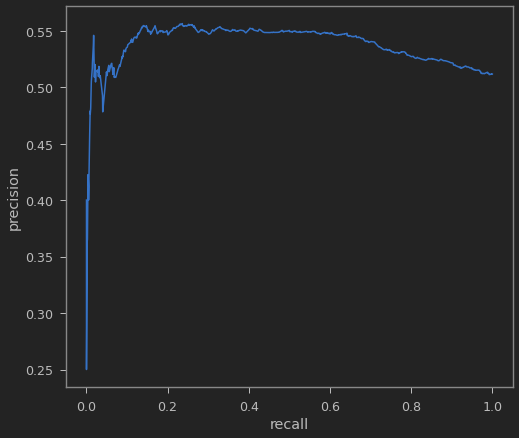

In [87]:
plt.plot(scores['recall'],scores['precision'])
plt.ylabel('precision')
plt.xlabel('recall')

In [89]:
# Find threshold that guarantees 0.8 recall score
scores[scores['precision'] == scores['precision'].max()].threshold.max()

0.60522324

In [66]:
from sklearn.metrics import recall_score, precision_score, f1_score

In [90]:
model = LogisticRegression()
model.fit(X_train_0, y_train_0_classifier)

def custom_predict(X, custom_threshold):
    probs = model.predict_proba(X) # Get likelihood of each sample being classified as 0 or 1
    expensive_probs = probs[:, 1] # Only keep expensive likelihoods (1) 
    return (expensive_probs > custom_threshold).astype(int) # Boolean outcome converted to 0 or 1
    
    
updated_preds = custom_predict(X=X_train_0, custom_threshold=0.60522324) # Update predictions 

print(recall_score(y_train_0_classifier, updated_preds)) # Rerun recall
print(precision_score(y_train_0_classifier, updated_preds)) # Rerun precision
print(f1_score(y_train_0_classifier, updated_preds)) # Rerun f1

0.08920765027322404
0.6823406478578893
0.1577866376706536


### Custom Scorer

In [91]:
type(updated_preds)

numpy.ndarray

In [92]:
pd.DataFrame(updated_preds).value_counts()

0    13352
1      957
dtype: int64

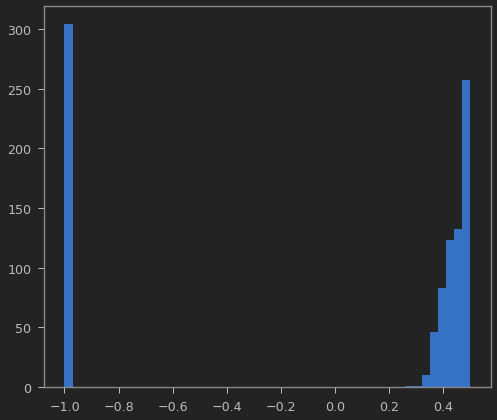

In [93]:
plt.hist(y_train_0[updated_preds==1], bins=50);

In [94]:
y_train_0[updated_preds==1].sum()

-14.700000000000019

### Randomized Search - Hyperparams

In [96]:
from sklearn.model_selection import RandomizedSearchCV
from scipy import stats

In [131]:
model = xgb.XGBClassifier()

parameters = {
    'booster': ['gbtree'],
    'max_depth': [3, 5, 7,10,15],
    'reg_lambda':[1,1.5,2, 2.5,3],
    'n_estimators': range(60, 500, 50),
}

# fit_params = {"early_stopping_rounds":[20, 40, 60, 80],
#               "eval_metric": 'r2_score'
#               "eval_set": [[X_test_0, y_test_0]]
#              }

random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=parameters,
    n_iter = 100,
    n_jobs = -1,
    cv = 5,
    verbose=1
)

random_search.fit(X_train_0,y_train_0_classifier);
random_search.best_estimator_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=60, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=2, ...)

In [132]:
print(random_search.best_estimator_)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=60, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=2, ...)


Iniciando modelo pré treinado


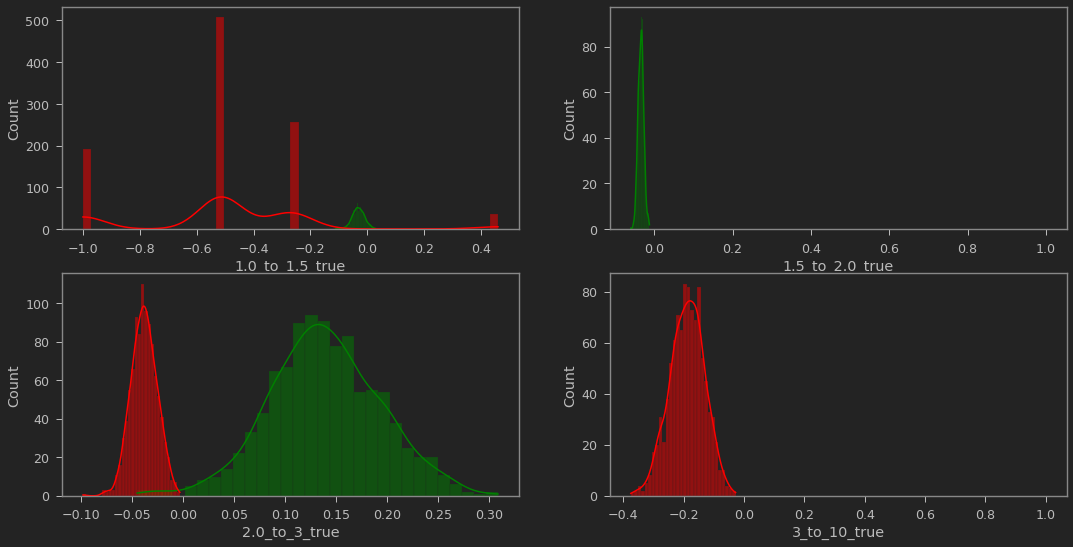

In [155]:
model_classifier_results(n=1000, m=random_search.best_estimator_)

In [149]:
6596*0.2/365

3.6142465753424657

### Learning Curves

In [134]:
from sklearn.model_selection import cross_val_score, learning_curve

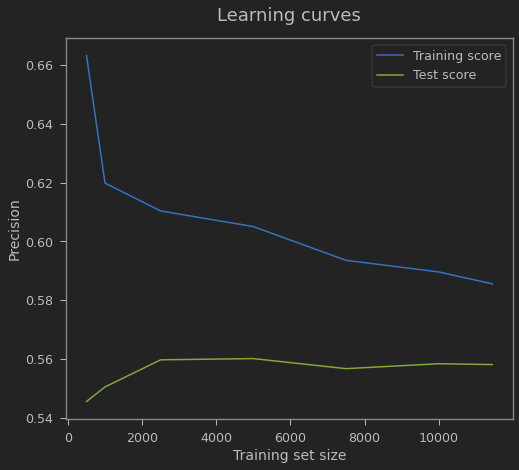

In [135]:
train_sizes = [1,500,1000,2500,5000,7500,10000,11447]

# Get train scores (R2), train sizes, and validation scores using `learning_curve`

train_sizes, train_scores, test_scores = learning_curve(
estimator=random_search.best_estimator_, X=X_train_0, y=y_train_0_classifier, train_sizes=train_sizes, cv=5)

# Take the mean of cross-validated train scores and validation scores

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
plt.plot(train_sizes, train_scores_mean, label = 'Training score');
plt.plot(train_sizes, test_scores_mean, label = 'Test score');
plt.ylabel('Precision', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves', fontsize = 18, y = 1.03)
plt.legend();